# Lab -  Anomaly Detection

**Objectives**: implement Gaussian distribution model to detect anomalous behavior in server computers. 

While the servers were operating, data regarding the through-put (mb/s) and latency (ms) of response of each server were collected. Vast majority of the servers were acting normal but a few servers were acting anomalously.
On that dataset you will ﬁt a Gaussian distribution of the server features and then identify which are the anomalous samples. 

In [2]:
# Loading relevant libraries
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=RuntimeWarning)

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import matplotlib
%matplotlib inline

### Load Data 
Load data from file ex9data.mat and get train, test and validation data.

In [7]:
mat = loadmat('ex9data.mat')
Xtrain = mat['Xtrain'] # only normal examples
Xtest = mat['Xtest'] # normal and a few abnormal examples
Xval = mat['Xval'] # normal and a few abnormal examples
yval = mat['yval'] # labels of the validation examples

# What is the shape of each variable, what is the meaning of the rows and the columns?
print("Shape train:", Xtrain.shape)
print("Shape test:", Xtest.shape)
print("Shape validation:", Xval.shape)
print("Shape y validation:", yval.shape)
# How many are the normal (label 0) and the abnormal (label 1) validation samples ?
normal = np.sum(yval == 0)  # Count of normal samples
abnormal = np.sum(yval == 1)  # Count of abnormal samples

print("Normal samples in yval:", normal)
print("Abnormal samples in yval:", abnormal)

Shape train: (300, 2)
Shape test: (307, 2)
Shape validation: (307, 2)
Shape y validation: (307, 1)
Normal samples in yval: 298
Abnormal samples in yval: 9


### Plot data

<img src="images/im1.png" style="width:600px;height:300px;">
<caption><center> **Fig. 1** : **Latency versus Throughput** </center></caption>

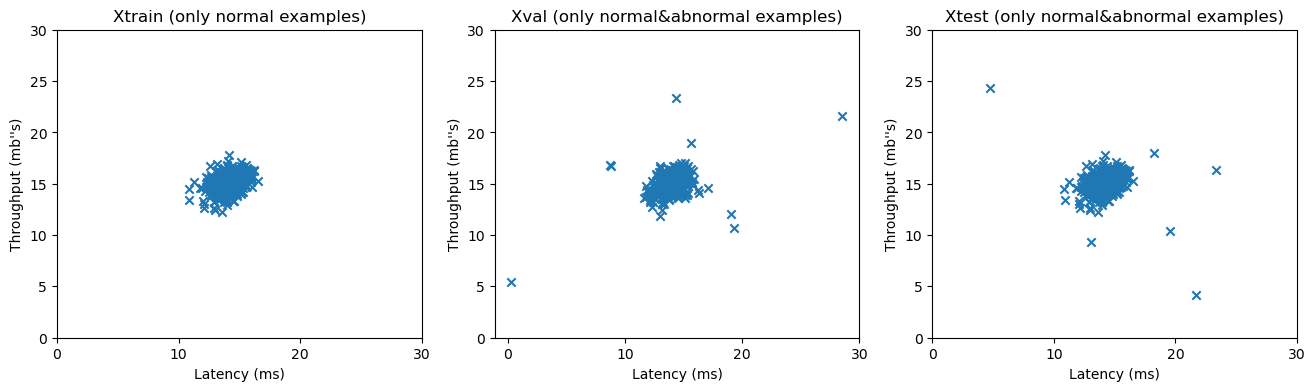

In [15]:
# Plot the scater plots of (Xtrain,Xval, Xtest) and get figure similar to Fig. 1. 
plt.figure(figsize=(16,4))

plt.subplot(1, 3, 1)
plt.scatter(Xtrain[:,0], Xtrain[:,1], marker='x')
plt.xticks(np.arange(0, 40, 10))
plt.yticks(np.arange(0, 35, 5))
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb'\'s)")
plt.title("Xtrain (only normal examples)")

plt.subplot(1, 3, 2)
plt.scatter(Xval[:,0], Xval[:,1], marker='x')
plt.xticks(np.arange(0, 40, 10))
plt.yticks(np.arange(0, 35, 5))
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb'\'s)")
plt.title("Xval (only normal&abnormal examples)")

plt.subplot(1, 3, 3)
plt.scatter(Xtest[:,0], Xtest[:,1], marker='x')
plt.xticks(np.arange(0, 40, 10))
plt.yticks(np.arange(0, 35, 5))
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb'\'s)")
plt.title("Xtest (only normal&abnormal examples)")

plt.show()

### Plot Data

<img src="images/im2.png" style="width:300px;height:250px;">
<caption><center> **Fig. 2** : **Data distribution** </center></caption>

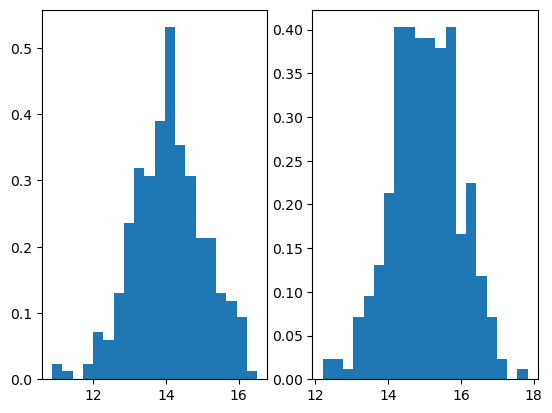

In [17]:
# Plot the histograms of each feature and get figure simular to Fig.2.
plt.subplot(1, 2, 1)
plt.hist(Xtrain[:,0], 20, density=1)

plt.subplot(1, 2, 2)
plt.hist(Xtrain[:,1], 20, density=1)

plt.show()

### Gaussian Distribution

To perform anomaly detection, you first need to fit a model only to the normal data.

Given a training set {x(1), …, x(m)} (where x(i) ∈ R^n, here n = 2), you want to estimate the Gaussian distribution for each feature (i = 1 . . . n), i.e. find mean and variance (mu, sigma²). 

Gaussian distribution:  $p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(x-\mu)^2}{2\sigma^2}}$

mean:  $\mu_i = \frac{1}{m}\sum^m_{j=1}x^{(j)}$

variance:  $\sigma^2_i = \frac{1}{m}\sum^m_{j=1}(x^{(j)} - \mu_j)^2$

In [18]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    m = X.shape[0]  #number of examples in X
    
    # compute the mean of X per column
    mu = np.mean(X, axis=0)
     
    # compute variance =sigma^2 of X per column
    sigma2 = (1/m) * np.sum((X - mu)**2, axis=0)
    
    return mu,sigma2

In [20]:
# Estimate mean and variance for the Gaussian model of NORMAL data (Xtrain)
# ANSWER: mu =  [14.06411334 15.02441479] ; sigma2 = [0.93434723 0.8506542 ]

mu, sigma2 = estimateGaussian(Xtrain)

print(f'mu = {mu} ; sigma2 = {sigma2}')

mu = [14.06411334 15.02441479] ; sigma2 = [0.93434723 0.8506542 ]


### Multivariate Gaussian Distribution

Inside function *multivariateGaussian*, $\sigma^2$ vector is converted into the covariance matrix  $\Sigma$.  Assuming the features are independent, each element of vector $\sigma^2$ will be on the diagonal of matrix $\Sigma$ and the rest of the elements are 0. 

The formula for the multivariate probability distribution is:

$p(x;\mu,\Sigma) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))$

In [21]:
# Complete the function
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate Gaussian distribution.
    """
    n = X.shape[1] # number of features 
    sigma_diag=np.diag(sigma2)  # Diagonal matrix (features are independent !!!!)
    X = X - mu.T
    p = 1/((2*np.pi)**(n/2)*(np.linalg.det(sigma_diag)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma_diag) * X,axis=1))
    return p

### Select the threshold $\epsilon$  that will flag an example as anomaly

Dataset is highly unbalanced, accuracy is not a good metrics, therefore F1 score is used to determine the best epsilon. Best parameters are the ones in which F1 score is maximum.

Predict anomaly if pval<epsilon !

Note: try-except block is used to excape zero division when compute precision and recall.

In [24]:
# Complete the function
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to separate normal/anomalous samples
    Best epsilon is when F1 score is max 
    """
    best_epi = 0
    best_F1 = 0
    
    # range of threshold values to decide the best one. 
    stepsize = (max(pval) -min(pval))/1000
    epi_range = np.arange(pval.min(),pval.max(),stepsize)
    for epi in epi_range:
        
        # predictions is a binary vector
        predictions = (pval<epi)[:,np.newaxis]
        
        # compute true positive
        tp = np.sum(predictions[yval == 1] == 1)
        
        # compute false positive
        fp = np.sum(predictions[yval == 0] == 1)
        
        # compute false negative 
        fn = np.sum(predictions[yval == 1] == 0)
        
        try:
        # compute precision
            prec = tp/(tp + fp)
            
            # compute recall
            rec = tp/(tp + fn)
            
            # compute  F1
            F1 = 2*(rec*prec)/(rec+prec)
        
            if F1 > best_F1:
                best_F1 =F1
                best_epi = epi
            
        except ZeroDivisionError:
                print('Warning dividing by zero!!')  
        
    return best_epi, best_F1

In [25]:
# Apply multivariateGaussian to compute the probability of the examples in Xval. 
pval = multivariateGaussian(Xval, mu, sigma2)

# Apply selectThreshold to compute the best epsilon and best F1 with the validation data
epsilon, F1 = selectThreshold(yval, pval)

# What is the Best epsilon ?  => ANSWER: 0.00018
print("Best epsilon:", epsilon)

# What is the Best F1 ? => ANSWER: 0.8235
print("Best F1:", F1)

Best epsilon: 0.00017841159895769934
Best F1: 0.823529411764706


**findIndices** returns the indices of faulty servers. This gives a binary vector where 1 means anomaly and 0 means normal.

In [26]:
def findIndices(binVec):
    l = []
    for i in range(len(binVec)):
        if binVec[i] == 1:
            l.append(i)
    return l

In [31]:
# Apply multivariateGaussian to compute the probability of the examples in Xtest
p = multivariateGaussian(Xtest, mu, sigma2)

outl = (p < epsilon)
listOfOutliers=findIndices(outl)

# How many are the Outliers => #ANSWER: 6
print("Number of Outliers:", len(listOfOutliers))
 
# print them
for out in range (len(listOfOutliers)):
    print(f'Outlier {out}: {listOfOutliers[out]}')

Number of Outliers: 6
Outlier 0: 300
Outlier 1: 301
Outlier 2: 303
Outlier 3: 304
Outlier 4: 305
Outlier 5: 306


### Visualize the anomalies

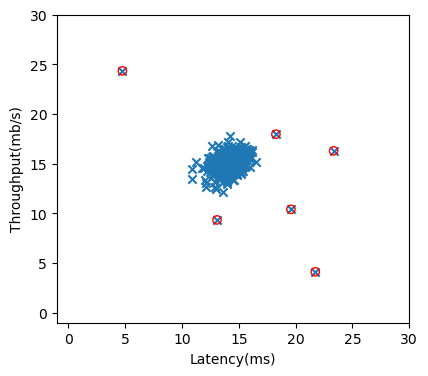

In [32]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.scatter(Xtest[:, 0], Xtest[:, 1], marker = "x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.scatter(Xtest[listOfOutliers,0], Xtest[listOfOutliers, 1], facecolors = 'none', edgecolors = 'r')
plt.xlim(-1,30)
plt.ylim(-1,30)
plt.show()